In [1]:
import warnings


# ClaimChain  -  SHAP value  determination using Insurance claim data set

In [2]:
import numpy as np
import pandas as pd
import joypy

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import plotting
from pandas.plotting import parallel_coordinates

In [4]:
# for interactive visualizations
import plotly
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected = True)
import plotly.figure_factory as ff

In [6]:
from bubbly.bubbly import bubbleplot
import plotly_express as px

In [7]:
import os

In [8]:
#for modelling:
import sklearn
import imblearn

In [9]:
import eli5
import shap

In [10]:


# let's import the data
data = pd.read_csv('claimchain.csv')

data.head()



,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,17-10-2014,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,27-06-2006,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,6/9/2000,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,25-05-1990,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,6/6/2014,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [11]:
data.info

<bound method DataFrame.info of      months_as_customer  age  policy_number policy_bind_date policy_state  \
0                   328   48         521585       17-10-2014           OH   
1                   228   42         342868       27-06-2006           IN   
2                   134   29         687698         6/9/2000           OH   
3                   256   41         227811       25-05-1990           IL   
4                   228   44         367455         6/6/2014           IL   
..                  ...  ...            ...              ...          ...   
995                   3   38         941851       16-07-1991           OH   
996                 285   41         186934         5/1/2014           IL   
997                 130   34         918516       17-02-2003           OH   
998                 458   62         533940       18-11-2011           IL   
999                 456   60         556080       11/11/1996           OH   

    policy_csl  policy_deductable  policy_a

# Selecting Shortlisted Features - (Green Highlighted Columns)

In [12]:
subset = data[['months_as_customer','age','policy_annual_premium','insured_sex','insured_occupation','insured_hobbies','incident_type','incident_severity','incident_date','policy_bind_date','authorities_contacted','total_claim_amount','police_report_available','fraud_reported']]

In [13]:
subset.head()

,months_as_customer,age,policy_annual_premium,insured_sex,insured_occupation,insured_hobbies,incident_type,incident_severity,incident_date,policy_bind_date,authorities_contacted,total_claim_amount,police_report_available,fraud_reported
0,328,48,1406.91,MALE,craft-repair,sleeping,Single Vehicle Collision,Major Damage,25-01-2015,17-10-2014,Police,71610,YES,Y
1,228,42,1197.22,MALE,machine-op-inspct,reading,Vehicle Theft,Minor Damage,21-01-2015,27-06-2006,Police,5070,?,Y
2,134,29,1413.14,FEMALE,sales,board-games,Multi-vehicle Collision,Minor Damage,22-02-2015,6/9/2000,Police,34650,NO,N
3,256,41,1415.74,FEMALE,armed-forces,board-games,Single Vehicle Collision,Major Damage,10/1/2015,25-05-1990,Police,63400,NO,Y
4,228,44,1583.91,MALE,sales,board-games,Vehicle Theft,Minor Damage,17-02-2015,6/6/2014,None,6500,NO,N


In [15]:
subset.head()

,months_as_customer,age,policy_annual_premium,insured_sex,insured_occupation,insured_hobbies,incident_type,incident_severity,incident_date,policy_bind_date,authorities_contacted,total_claim_amount,police_report_available,fraud_reported
0,328,48,1406.91,MALE,craft-repair,sleeping,Single Vehicle Collision,Major Damage,25-01-2015,17-10-2014,Police,71610,YES,Y
1,228,42,1197.22,MALE,machine-op-inspct,reading,Vehicle Theft,Minor Damage,21-01-2015,27-06-2006,Police,5070,?,Y
2,134,29,1413.14,FEMALE,sales,board-games,Multi-vehicle Collision,Minor Damage,22-02-2015,6/9/2000,Police,34650,NO,N
3,256,41,1415.74,FEMALE,armed-forces,board-games,Single Vehicle Collision,Major Damage,10/1/2015,25-05-1990,Police,63400,NO,Y
4,228,44,1583.91,MALE,sales,board-games,Vehicle Theft,Minor Damage,17-02-2015,6/6/2014,None,6500,NO,N


In [16]:
pd.__version__

'1.1.3'

In [17]:
subset.shape

(1000, 14)

In [18]:
subset.cov()

,months_as_customer,age,policy_annual_premium,total_claim_amount
months_as_customer,13251.042927,970.201810,141.031474,1.887564e+05
age,970.201810,83.544841,32.145675,1.685908e+04
policy_annual_premium,141.031474,32.145675,59617.716762,5.862176e+04
total_claim_amount,188756.405646,16859.079960,58621.757226,6.970410e+08


In [19]:
subset = subset.replace('?',np.NaN)

subset.isnull().any()

months_as_customer         False
age                        False
policy_annual_premium      False
insured_sex                False
insured_occupation         False
insured_hobbies            False
incident_type              False
incident_severity          False
incident_date              False
policy_bind_date           False
authorities_contacted      False
total_claim_amount         False
police_report_available     True
fraud_reported             False
dtype: bool

In [20]:

fraud = subset['fraud_reported'].value_counts()


In [21]:

label_fraud = fraud.index

size_fraud = fraud.values


In [22]:

colors = ['silver','gold']

trace = go.Pie(labels = label_fraud, values = size_fraud, marker = dict(colors = colors), name = 'Frauds', hole = 0.3 )


In [24]:

df = [trace]

layout = go.Layout(title = 'Distribution of Frauds')

fig = go.Figure(data = df, layout = layout)

py.iplot(fig)


In [25]:
# let's encode the fraud report to numerical values

subset['fraud_reported'] = subset['fraud_reported'].replace(('Y','N'),(0,1))

# Data Processing: 

In [26]:

import datetime
subset['policy_blind_date'] = pd.to_datetime(subset['policy_bind_date'], errors = 'coerce')

In [27]:
subset = subset.replace('?',np.NaN)

subset.isnull().any()

months_as_customer         False
age                        False
policy_annual_premium      False
insured_sex                False
insured_occupation         False
insured_hobbies            False
incident_type              False
incident_severity          False
incident_date              False
policy_bind_date           False
authorities_contacted      False
total_claim_amount         False
police_report_available     True
fraud_reported             False
policy_blind_date          False
dtype: bool

In [28]:
# missing value treatment using fillna

subset['police_report_available'].fillna('NO', inplace = True)



In [29]:
subset = subset.replace('?',np.NaN)

subset.isnull().any()

months_as_customer         False
age                        False
policy_annual_premium      False
insured_sex                False
insured_occupation         False
insured_hobbies            False
incident_type              False
incident_severity          False
incident_date              False
policy_bind_date           False
authorities_contacted      False
total_claim_amount         False
police_report_available    False
fraud_reported             False
policy_blind_date          False
dtype: bool

# Replacing all the string and boolean values to numerical values for Evaluation Purpose:
Using Correalation of those features with the target value


In [30]:
# Relation between Authorities contactes  and  TARGET (fraud reported)

subset[['authorities_contacted','fraud_reported']].groupby(['authorities_contacted'], 
                as_index = False).mean().sort_values(by = 'fraud_reported', ascending = False)

,authorities_contacted,fraud_reported
2,None,0.934066
4,Police,0.791096
1,Fire,0.730942
0,Ambulance,0.709184
3,Other,0.681818


In [32]:
subset.head()

,months_as_customer,age,policy_annual_premium,insured_sex,insured_occupation,insured_hobbies,incident_type,incident_severity,incident_date,policy_bind_date,authorities_contacted,total_claim_amount,police_report_available,fraud_reported,policy_blind_date
0,328,48,1406.91,MALE,craft-repair,sleeping,Single Vehicle Collision,Major Damage,25-01-2015,17-10-2014,Police,71610,YES,0,2014-10-17
1,228,42,1197.22,MALE,machine-op-inspct,reading,Vehicle Theft,Minor Damage,21-01-2015,27-06-2006,Police,5070,NO,0,2006-06-27
2,134,29,1413.14,FEMALE,sales,board-games,Multi-vehicle Collision,Minor Damage,22-02-2015,6/9/2000,Police,34650,NO,1,2000-06-09
3,256,41,1415.74,FEMALE,armed-forces,board-games,Single Vehicle Collision,Major Damage,10/1/2015,25-05-1990,Police,63400,NO,0,1990-05-25
4,228,44,1583.91,MALE,sales,board-games,Vehicle Theft,Minor Damage,17-02-2015,6/6/2014,None,6500,NO,1,2014-06-06


In [33]:
subset['authorities_contacted'] = subset['authorities_contacted'].replace(('None','Police','Fire','Ambulance','Other'),
                                                                      (0.94,0.79,0.73,0.70,0.68))


In [34]:
# Relation between 'Police Reports' and  TARGET (fraud reported)


subset[['police_report_available','fraud_reported']].groupby(['police_report_available'], 
                as_index = False).mean().sort_values(by = 'fraud_reported', ascending = False)

,police_report_available,fraud_reported
1,YES,0.770701
0,NO,0.744898


In [35]:
subset['police_report_available'] = subset['police_report_available'].replace(('YES', 'NO'),
                                                                      (0.77,0.74))

In [36]:
subset[['incident_severity','fraud_reported']].groupby(['incident_severity'], 
                as_index = False).mean().sort_values(by = 'fraud_reported', ascending = False)

,incident_severity,fraud_reported
3,Trivial Damage,0.933333
1,Minor Damage,0.892655
2,Total Loss,0.871429
0,Major Damage,0.394928


In [37]:
subset['incident_severity'] = subset['incident_severity'].replace(('Trivial Damage','Minor Damage','Total Loss',
                                                              'Major Damage'),(0.94,0.89,0.87,0.39))

In [38]:
subset.head()

,months_as_customer,age,policy_annual_premium,insured_sex,insured_occupation,insured_hobbies,incident_type,incident_severity,incident_date,policy_bind_date,authorities_contacted,total_claim_amount,police_report_available,fraud_reported,policy_blind_date
0,328,48,1406.91,MALE,craft-repair,sleeping,Single Vehicle Collision,0.39,25-01-2015,17-10-2014,0.79,71610,0.77,0,2014-10-17
1,228,42,1197.22,MALE,machine-op-inspct,reading,Vehicle Theft,0.89,21-01-2015,27-06-2006,0.79,5070,0.74,0,2006-06-27
2,134,29,1413.14,FEMALE,sales,board-games,Multi-vehicle Collision,0.89,22-02-2015,6/9/2000,0.79,34650,0.74,1,2000-06-09
3,256,41,1415.74,FEMALE,armed-forces,board-games,Single Vehicle Collision,0.39,10/1/2015,25-05-1990,0.79,63400,0.74,0,1990-05-25
4,228,44,1583.91,MALE,sales,board-games,Vehicle Theft,0.89,17-02-2015,6/6/2014,0.94,6500,0.74,1,2014-06-06


In [39]:
subset['incident_date'] = pd.to_datetime(subset['incident_date'], errors = 'coerce')

# extracting days and month from date
subset['incident_month'] = subset['incident_date'].dt.month
subset['incident_day'] = subset['incident_date'].dt.day

In [40]:
subset.head()

,months_as_customer,age,policy_annual_premium,insured_sex,insured_occupation,insured_hobbies,incident_type,incident_severity,incident_date,policy_bind_date,authorities_contacted,total_claim_amount,police_report_available,fraud_reported,policy_blind_date,incident_month,incident_day
0,328,48,1406.91,MALE,craft-repair,sleeping,Single Vehicle Collision,0.39,2015-01-25,17-10-2014,0.79,71610,0.77,0,2014-10-17,1,25
1,228,42,1197.22,MALE,machine-op-inspct,reading,Vehicle Theft,0.89,2015-01-21,27-06-2006,0.79,5070,0.74,0,2006-06-27,1,21
2,134,29,1413.14,FEMALE,sales,board-games,Multi-vehicle Collision,0.89,2015-02-22,6/9/2000,0.79,34650,0.74,1,2000-06-09,2,22
3,256,41,1415.74,FEMALE,armed-forces,board-games,Single Vehicle Collision,0.39,2015-10-01,25-05-1990,0.79,63400,0.74,0,1990-05-25,10,1
4,228,44,1583.91,MALE,sales,board-games,Vehicle Theft,0.89,2015-02-17,6/6/2014,0.94,6500,0.74,1,2014-06-06,2,17


In [41]:

subset[['insured_sex','fraud_reported']].groupby(['insured_sex'], as_index = False).mean().sort_values(
    by = 'fraud_reported', ascending = False)

,insured_sex,fraud_reported
0,FEMALE,0.765363
1,MALE,0.738661


In [42]:
subset['insured_sex'] = subset['insured_sex'].replace(('FEMALE','MALE'),(0.76,0.73))

In [43]:
subset.head()

,months_as_customer,age,policy_annual_premium,insured_sex,insured_occupation,insured_hobbies,incident_type,incident_severity,incident_date,policy_bind_date,authorities_contacted,total_claim_amount,police_report_available,fraud_reported,policy_blind_date,incident_month,incident_day
0,328,48,1406.91,0.73,craft-repair,sleeping,Single Vehicle Collision,0.39,2015-01-25,17-10-2014,0.79,71610,0.77,0,2014-10-17,1,25
1,228,42,1197.22,0.73,machine-op-inspct,reading,Vehicle Theft,0.89,2015-01-21,27-06-2006,0.79,5070,0.74,0,2006-06-27,1,21
2,134,29,1413.14,0.76,sales,board-games,Multi-vehicle Collision,0.89,2015-02-22,6/9/2000,0.79,34650,0.74,1,2000-06-09,2,22
3,256,41,1415.74,0.76,armed-forces,board-games,Single Vehicle Collision,0.39,2015-10-01,25-05-1990,0.79,63400,0.74,0,1990-05-25,10,1
4,228,44,1583.91,0.73,sales,board-games,Vehicle Theft,0.89,2015-02-17,6/6/2014,0.94,6500,0.74,1,2014-06-06,2,17


In [44]:
subset[['insured_occupation','fraud_reported']].groupby(['insured_occupation'], 
                as_index = False).mean().sort_values(by = 'fraud_reported', ascending = False)



,insured_occupation,fraud_reported
7,other-service,0.830986
8,priv-house-serv,0.830986
0,adm-clerical,0.830769
5,handlers-cleaners,0.796296
9,prof-specialty,0.788235
10,protective-serv,0.777778
6,machine-op-inspct,0.763441
1,armed-forces,0.753623
11,sales,0.723684
12,tech-support,0.717949


In [45]:
subset['insured_occupation'] = subset['insured_occupation'].replace(('other-service','priv-house-serv',
                        'adm-clerical','handlers-cleaners','prof-specialty','protective-serv',
                'machine-op-inspct','armed-forces','sales','tech-support','transport-moving','craft-repair',
                    'farming-fishing','exec-managerial'),(0.84, 0.84,0.83, 0.79,0.78,0.77,0.76,0.75,0.72,0.71,
                                                          0.705,0.70,0.69,0.63))

In [46]:
subset[['insured_hobbies','fraud_reported']].groupby(['insured_hobbies'], 
                as_index = False).mean().sort_values(by = 'fraud_reported', ascending = False)

,insured_hobbies,fraud_reported
4,camping,0.909091
11,kayaking,0.907407
9,golf,0.890909
7,dancing,0.883721
3,bungie-jumping,0.839286
12,movies,0.836364
1,basketball,0.823529
8,exercise,0.807018
17,sleeping,0.804878
18,video-games,0.800000


In [47]:
subset['insured_hobbies'] = subset['insured_hobbies'].replace(('camping', 'kayaking', 'golf','dancing',
        'bungie-jumping','movies', 'basketball','exercise','sleeping','video-games','skydiving','paintball',
            'hiking','base-jumping','reading','polo','board-games','yachting', 'cross-fit','chess'),(0.91, 0.90,
                0.89, 0.88,0.84,0.83,0.82,0.81,0.805,0.80,0.78,0.77,0.76,0.73,0.73,0.72,0.70,0.69,0.25,0.17))

In [48]:
subset[['incident_type','fraud_reported']].groupby(['incident_type'], 
                as_index = False).mean().sort_values(by = 'fraud_reported', ascending = False)

,incident_type,fraud_reported
3,Vehicle Theft,0.914894
1,Parked Car,0.904762
0,Multi-vehicle Collision,0.727924
2,Single Vehicle Collision,0.709677


In [49]:
subset['incident_type'] = subset['incident_type'].replace(('Vehicle Theft','Parked Car','Multi-vehicle Collision',
                                'Single Vehicle Collision'),(0.91, 0.90, 0.72,0.70))

In [50]:
subset.head()

,months_as_customer,age,policy_annual_premium,insured_sex,insured_occupation,insured_hobbies,incident_type,incident_severity,incident_date,policy_bind_date,authorities_contacted,total_claim_amount,police_report_available,fraud_reported,policy_blind_date,incident_month,incident_day
0,328,48,1406.91,0.73,0.70,0.805,0.70,0.39,2015-01-25,17-10-2014,0.79,71610,0.77,0,2014-10-17,1,25
1,228,42,1197.22,0.73,0.76,0.730,0.91,0.89,2015-01-21,27-06-2006,0.79,5070,0.74,0,2006-06-27,1,21
2,134,29,1413.14,0.76,0.72,0.700,0.72,0.89,2015-02-22,6/9/2000,0.79,34650,0.74,1,2000-06-09,2,22
3,256,41,1415.74,0.76,0.75,0.700,0.70,0.39,2015-10-01,25-05-1990,0.79,63400,0.74,0,1990-05-25,10,1
4,228,44,1583.91,0.73,0.72,0.700,0.91,0.89,2015-02-17,6/6/2014,0.94,6500,0.74,1,2014-06-06,2,17


In [51]:
subset.head()

,months_as_customer,age,policy_annual_premium,insured_sex,insured_occupation,insured_hobbies,incident_type,incident_severity,incident_date,policy_bind_date,authorities_contacted,total_claim_amount,police_report_available,fraud_reported,policy_blind_date,incident_month,incident_day
0,328,48,1406.91,0.73,0.70,0.805,0.70,0.39,2015-01-25,17-10-2014,0.79,71610,0.77,0,2014-10-17,1,25
1,228,42,1197.22,0.73,0.76,0.730,0.91,0.89,2015-01-21,27-06-2006,0.79,5070,0.74,0,2006-06-27,1,21
2,134,29,1413.14,0.76,0.72,0.700,0.72,0.89,2015-02-22,6/9/2000,0.79,34650,0.74,1,2000-06-09,2,22
3,256,41,1415.74,0.76,0.75,0.700,0.70,0.39,2015-10-01,25-05-1990,0.79,63400,0.74,0,1990-05-25,10,1
4,228,44,1583.91,0.73,0.72,0.700,0.91,0.89,2015-02-17,6/6/2014,0.94,6500,0.74,1,2014-06-06,2,17


In [78]:


# let's delete unnecassary columns

subset = subset.drop(['policy_bind_date','incident_date'], axis = 1)


In [80]:
subset.head()

,months_as_customer,age,policy_annual_premium,insured_sex,insured_occupation,insured_hobbies,incident_type,incident_severity,authorities_contacted,total_claim_amount,police_report_available,fraud_reported,incident_month,incident_day
0,328,48,1406.91,0.73,0.70,0.805,0.70,0.39,0.79,71610,0.77,0,1,25
1,228,42,1197.22,0.73,0.76,0.730,0.91,0.89,0.79,5070,0.74,0,1,21
2,134,29,1413.14,0.76,0.72,0.700,0.72,0.89,0.79,34650,0.74,1,2,22
3,256,41,1415.74,0.76,0.75,0.700,0.70,0.39,0.79,63400,0.74,0,10,1
4,228,44,1583.91,0.73,0.72,0.700,0.91,0.89,0.94,6500,0.74,1,2,17


In [81]:
subset.columns


Index(['months_as_customer', 'age', 'policy_annual_premium', 'insured_sex',
       'insured_occupation', 'insured_hobbies', 'incident_type',
       'incident_severity', 'authorities_contacted', 'total_claim_amount',
       'police_report_available', 'fraud_reported', 'incident_month',
       'incident_day'],
      dtype='object')

# Analysis: Using Machine Learning models

In [90]:
x = subset.drop(['fraud_reported'], axis = 1)
y = subset['fraud_reported']

print("Shape of x :", x.shape)
print("Shape of y :", y.shape)

Shape of x : (1000, 13)
Shape of y : (1000,)


In [91]:


# let's split the dataset into train and test sets

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

print("Shape of x_train :", x_train.shape)
print("Shape of x_test :", x_test.shape)
print("Shape of y_train :", y_train.shape)
print("Shape of y_test :", y_test.shape)



Shape of x_train : (800, 13)
Shape of x_test : (200, 13)
Shape of y_train : (800,)
Shape of y_test : (200,)


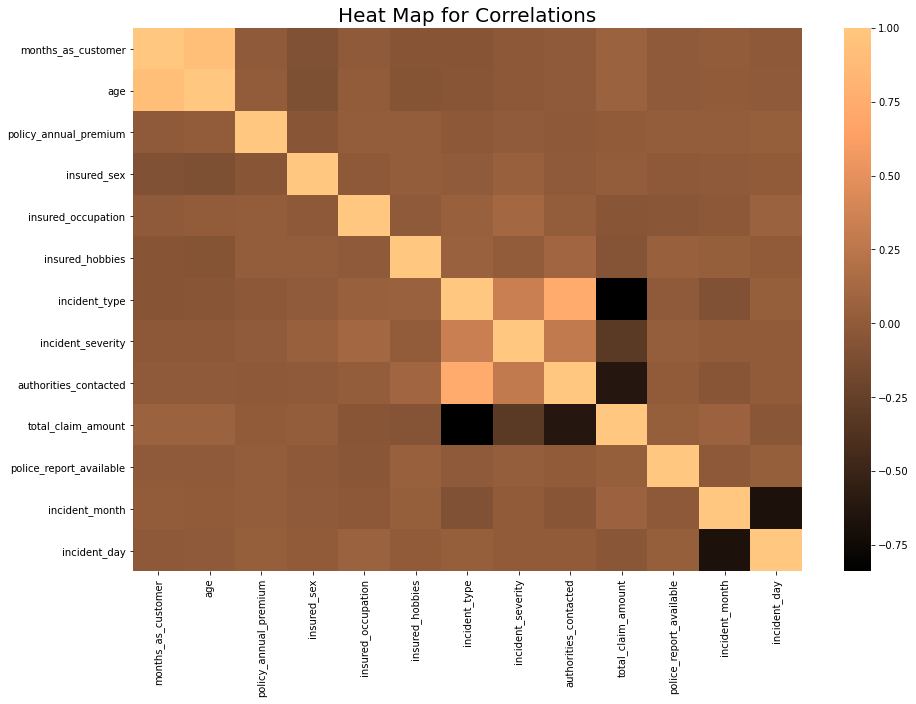

In [92]:


plt.rcParams['figure.figsize'] = (15, 10)
sns.heatmap(x_train.corr(), cmap = 'copper')
plt.title('Heat Map for Correlations', fontsize = 20)
plt.show()



# (Ensemble of samplers) : 1. Random Forest Classifier

In [93]:

from imblearn.ensemble import BalancedRandomForestClassifier 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [94]:

                 
model = BalancedRandomForestClassifier(n_estimators = 100, random_state = 0)

Training Accuracy:  0.89
Testing Accuarcy:  0.85
              precision    recall  f1-score   support

           0       0.70      0.84      0.76        57
           1       0.93      0.85      0.89       143

    accuracy                           0.85       200
   macro avg       0.81      0.85      0.83       200
weighted avg       0.86      0.85      0.85       200



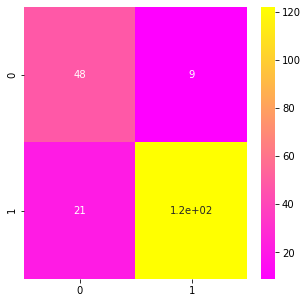

In [96]:


model.fit(x_train, y_train)
y_pred_rf = model.predict(x_test)

print("Training Accuracy: ", model.score(x_train, y_train))
print('Testing Accuarcy: ', model.score(x_test, y_test))

# making a classification report
cr = classification_report(y_test,  y_pred_rf)
print(cr)

# making a confusion matrix
plt.rcParams['figure.figsize'] = (5, 5)
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot = True, cmap = 'spring')
plt.show()

Easy Ensemble Classifier:

Training Accuracy:  0.8475
Testing Accuarcy:  0.82
              precision    recall  f1-score   support

           0       0.65      0.81      0.72        57
           1       0.91      0.83      0.87       143

    accuracy                           0.82       200
   macro avg       0.78      0.82      0.79       200
weighted avg       0.84      0.82      0.83       200



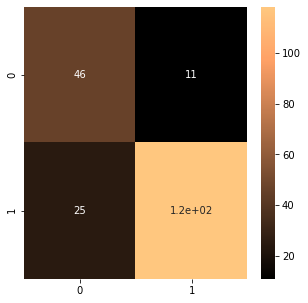

In [97]:

from imblearn.ensemble import EasyEnsembleClassifier 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
                 

model1 = EasyEnsembleClassifier(n_estimators = 100, random_state = 0)

model1.fit(x_train, y_train)
y_pred_ef = model1.predict(x_test)

print("Training Accuracy: ", model1.score(x_train, y_train))
print('Testing Accuarcy: ', model1.score(x_test, y_test))

# making a classification report
cr = classification_report(y_test,  y_pred_ef)
print(cr)

cm = confusion_matrix(y_test, y_pred_ef)
sns.heatmap(cm, annot = True, cmap = 'copper')
plt.show()

Training Accuracy:  0.91125
Testing Accuarcy:  0.855
              precision    recall  f1-score   support

           0       0.71      0.84      0.77        57
           1       0.93      0.86      0.89       143

    accuracy                           0.85       200
   macro avg       0.82      0.85      0.83       200
weighted avg       0.87      0.85      0.86       200



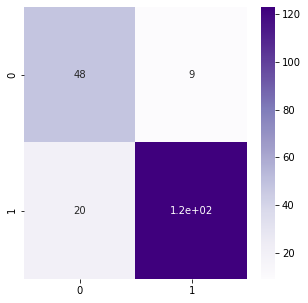

In [98]:
# Random Forest with Bagging Classifier

from imblearn.ensemble import BalancedBaggingClassifier 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
                 

model2 = BalancedBaggingClassifier(base_estimator = RandomForestClassifier(),
                                 sampling_strategy = 'auto',
                                 replacement = False,
                                 random_state = 0)

model2.fit(x_train, y_train)
y_pred_bc = model2.predict(x_test)

print("Training Accuracy: ", model2.score(x_train, y_train))
print('Testing Accuarcy: ', model2.score(x_test, y_test))

# making a classification report
cr = classification_report(y_test,  y_pred_bc)
print(cr)

# making a confusion matrix
cm = confusion_matrix(y_test, y_pred_bc)
sns.heatmap(cm, annot = True, cmap = 'Purples')
plt.show()

# Boosting The Predictions:

              precision    recall  f1-score   support

           0       0.70      0.84      0.76        57
           1       0.93      0.85      0.89       143

    accuracy                           0.85       200
   macro avg       0.81      0.85      0.83       200
weighted avg       0.86      0.85      0.85       200



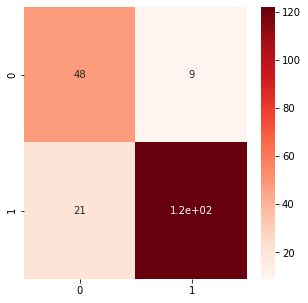

In [99]:


# boosting

y_pred = y_pred_rf*0.5 + y_pred_ef*0.2 + y_pred_bc*0.3

y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0

# making a classification report
cr = classification_report(y_test,  y_pred)
print(cr)

# making a confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, cmap = 'Reds')
plt.show()



              precision    recall  f1-score   support

           0       0.70      0.81      0.75        57
           1       0.92      0.86      0.89       143

    accuracy                           0.84       200
   macro avg       0.81      0.83      0.82       200
weighted avg       0.85      0.84      0.85       200



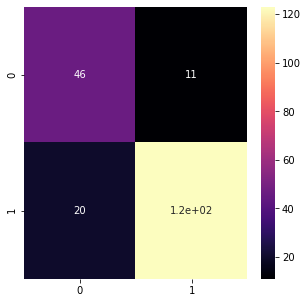

In [100]:
# Voting Classifier:

from sklearn.ensemble import VotingClassifier

vote_est = [ 
    ('brf', BalancedRandomForestClassifier()),
    ('bc', BalancedBaggingClassifier()),
    ('eec',EasyEnsembleClassifier())]

voting = VotingClassifier(estimators = vote_est , voting = 'soft')
voting.fit(x_train, y_train)

y_pred = voting.predict(x_test).astype(int)

# making a classification report
cr = classification_report(y_test,  y_pred)
print(cr)

# making a confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, cmap = 'magma')
plt.show()



# Applying Sampling Techniques:

In [101]:


y.value_counts()



1    753
0    247
Name: fraud_reported, dtype: int64

In [102]:
frauds = np.array(subset[subset['fraud_reported'] == 0].index)
no_frauds = len(frauds)

print("Number of Frauds:",no_frauds)

Number of Frauds: 247


In [103]:


normal_indices = subset[subset['fraud_reported'] == 1]
no_normal_indices = len(normal_indices)

print( "Valid Cliams :",no_normal_indices)



Valid Cliams : 753


In [104]:


random_normal_indices = np.random.choice(no_normal_indices, size = no_frauds, replace = True)
random_normal_indices = np.array(random_normal_indices)

print(len(random_normal_indices))

247


In [105]:
#Undersampling:

under_sample = np.concatenate([frauds, random_normal_indices])
print(len(under_sample))



494


In [106]:
# creating the undersample data

undersample_data = subset.iloc[under_sample, :]

In [107]:


# splitting the undersample dataset into x and y sets

x_u = undersample_data.iloc[:, undersample_data.columns != 'fraud_reported'] 
y_u = undersample_data.iloc[:, undersample_data.columns == 'fraud_reported']

print(x_u.shape)
print(y_u.shape)



(494, 13)
(494, 1)


In [108]:


from sklearn.model_selection import train_test_split

x_train1, x_test1, y_train1, y_test1 = train_test_split(x_u, y_u, test_size = 0.2, random_state = 0)

print(x_train1.shape)
print(y_train1.shape)
print(x_test1.shape)



(395, 13)
(395, 1)
(99, 13)


In [109]:

#Standardization

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train1 = sc.fit_transform(x_train1)
x_test1 = sc.transform(x_test1)




Training Accuracy:  1.0
Testing Accuarcy:  0.8383838383838383


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


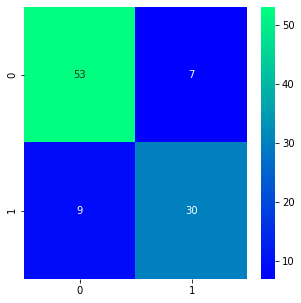

              precision    recall  f1-score   support

           0       0.85      0.88      0.87        60
           1       0.81      0.77      0.79        39

    accuracy                           0.84        99
   macro avg       0.83      0.83      0.83        99
weighted avg       0.84      0.84      0.84        99



In [110]:
from sklearn.ensemble import RandomForestClassifier

model_u = RandomForestClassifier()
model_u.fit(x_train1, y_train1)

y_pred = model_u.predict(x_test1)

print("Training Accuracy: ", model_u.score(x_train1, y_train1))
print('Testing Accuarcy: ', model_u.score(x_test1, y_test1))

# confusion matrix
cm = confusion_matrix(y_test1, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, cmap = 'winter')
plt.show()

# classification report
cr = classification_report(y_test1, y_pred)
print(cr)

In [111]:
from imblearn.over_sampling import SMOTE

x_resample, y_resample  = SMOTE().fit_resample(x, y.values.ravel())

print(x_resample.shape)
print(y_resample.shape)

(1506, 13)
(1506,)


In [112]:
from sklearn.model_selection import train_test_split

x_train2, x_test2, y_train2, y_test2 = train_test_split(x_resample, y_resample, test_size = 0.2, random_state = 0)

print(x_train2.shape)
print(y_train2.shape)
print(x_test2.shape)
print(y_test2.shape)

(1204, 13)
(1204,)
(302, 13)
(302,)


In [113]:
# standardization

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train2 = sc.fit_transform(x_train2)
x_test2 = sc.transform(x_test2)

Training Accuracy:  1.0
Testing Accuarcy:  0.8841059602649006


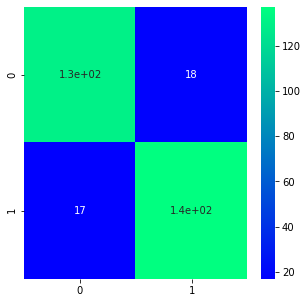

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       148
           1       0.88      0.89      0.89       154

    accuracy                           0.88       302
   macro avg       0.88      0.88      0.88       302
weighted avg       0.88      0.88      0.88       302



In [114]:


# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

model_o = RandomForestClassifier()
model_o.fit(x_train2, y_train2)

y_pred = model_o.predict(x_test2)

print("Training Accuracy: ", model_o.score(x_train2, y_train2))
print('Testing Accuarcy: ', model_o.score(x_test2, y_test2))

# confusion matrix
cm = confusion_matrix(y_test2, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, cmap = 'winter')
plt.show()

# classification report
cr = classification_report(y_test2, y_pred)
print(cr)



Model Explanation for Random Forest Classifier: 

In [115]:
from eli5.sklearn import PermutationImportance


perm = PermutationImportance(model, random_state = 0).fit(x_test, y_test)
eli5.show_weights(perm, feature_names = x_test.columns.tolist())

Weight,Feature
0.1870 ± 0.0338,incident_severity
0.0810 ± 0.0256,insured_hobbies
0.0010 ± 0.0117,insured_occupation
0 ± 0.0000,police_report_available
0 ± 0.0000,insured_sex
-0.0020 ± 0.0049,incident_month
-0.0030 ± 0.0049,incident_day
-0.0030 ± 0.0049,incident_type
-0.0040 ± 0.0133,total_claim_amount
-0.0040 ± 0.0040,policy_annual_premium


# SHAP Values:

In [116]:
import shap

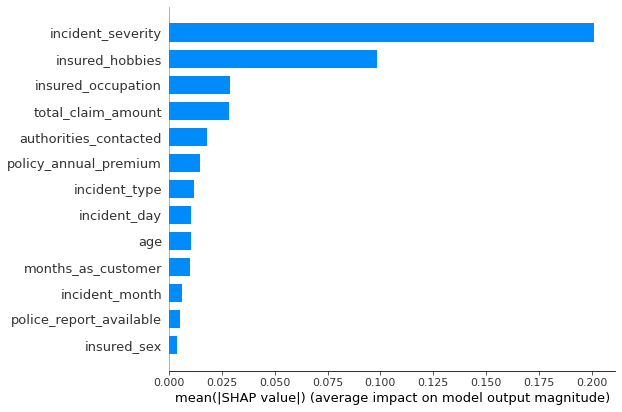

In [117]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)

shap.summary_plot(shap_values[1], x_test, plot_type="bar")

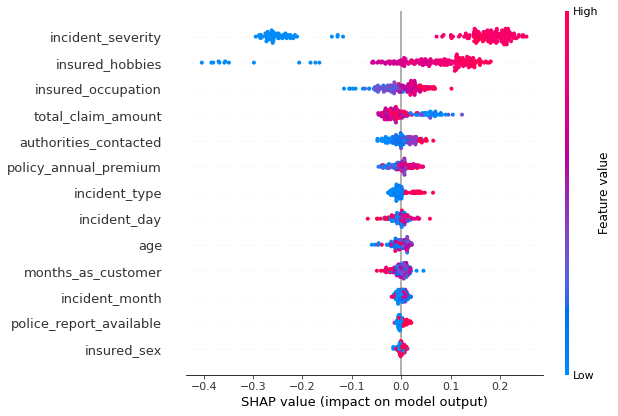

In [118]:
shap.summary_plot(shap_values[1],x_test)

In [119]:
# let's create a function to check the patient's conditions

def fraud_analysis(model, fraud):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(fraud)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], fraud)

In [120]:
# let's do some real time prediction for patients

fraud = x_test.iloc[1,:].astype(float)
fraud_analysis(model, fraud)

In [121]:
fraud = x_test.iloc[2,:].astype(float)
fraud_analysis(model, fraud)

In [122]:
fraud = x_test.iloc[3,:].astype(float)
fraud_analysis(model, fraud)

In [123]:
x_test

,months_as_customer,age,policy_annual_premium,insured_sex,insured_occupation,insured_hobbies,incident_type,incident_severity,authorities_contacted,total_claim_amount,police_report_available,incident_month,incident_day
993,124,28,1235.14,0.73,0.63,0.91,0.72,0.87,0.68,60200,0.74,2,17
859,130,30,1193.40,0.73,0.63,0.84,0.72,0.87,0.68,48950,0.74,2,2
298,194,35,1416.24,0.76,0.83,0.89,0.90,0.89,0.94,5940,0.74,2,26
553,428,53,1496.44,0.76,0.71,0.91,0.90,0.94,0.79,6930,0.74,2,16
672,61,25,988.06,0.76,0.84,0.88,0.72,0.89,0.70,32320,0.74,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,148,30,1471.24,0.76,0.69,0.91,0.72,0.89,0.79,32480,0.74,1,15
722,269,41,1422.21,0.76,0.79,0.72,0.70,0.39,0.70,85900,0.74,1,16
215,272,43,1279.13,0.73,0.70,0.84,0.72,0.89,0.70,81070,0.77,6,2
653,109,29,1007.28,0.76,0.83,0.83,0.72,0.89,0.79,91080,0.77,2,21


In [124]:
fraud = x_test.iloc[10,:].astype(float)
fraud_analysis(model, fraud)

In [125]:
shap_values = explainer.shap_values(x_train.iloc[:50])
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], x_test.iloc[:50])